# Methodology

1.First, we need to collect the data by scraping the table of HCMC units on the wikipedia page and the average housing price (AHP) on a website. The BeautifulSoup package is very useful in this case.

2.The column Density is calculated later based on columns Population and Area of each district.

3.Throughout the project, we use numpy and pandas packages to manipulate dataframes.

4.We use geopy.geocoders.Nominatim to get the coordinates of districts and add them to the main data frame.

5.We use folium package to visualize the HCMC map with its districts. The central coordinate of each district will be represented as a small circle on top of the city map.

6.We use Foursquare API to explore the venues in each district and segment the districts based on them.

7.For clustering the “Café" venues between districts, we use K-Means Clustering method and the package scikit-learn will help us implement the algorithm on our data. In order to indicate how many K for the method, we try with 10 different values of K from 1 to 10 and use the “elbow" method to choose the most appropriate one.

8.In order to visualize the charts, we use pakage matplotlib.

9.We use again the package folium to visualize the clusters on the main map and the choropleth map of AHP.

# Import all necessary packages

In [4]:
!pip install unidecode

import unidecode


import pandas as pd
import numpy as np

# convert an address into latitude and longitude values
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut
# tranform JSON file into a pandas dataframe
from pandas.io.json import json_normalize  

# Scrape the web to get the data
from bs4 import BeautifulSoup
import requests

import folium # map rendering library

# import k-means from clustering stage
from sklearn.cluster import KMeans

# find the distances
from scipy.spatial.distance import cdist

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# translate Vietnamese character (with accents) 
#     to the closest possible representation in ascii text
from unidecode import unidecode

     |████████████████████████████████| 245kB 12.4MB/s eta 0:00:01


### Collecting data

We don't have an all-in-one table, we have to collect all necessary information from various data tables.

First, we scrape the list of all 19 urban districts from a list of administrative units on a wiki page of Ho Chi Minh City.

In [5]:
source_wiki_hcm = requests.get("https://en.wikipedia.org/wiki/Ho_Chi_Minh_City").text
soup = BeautifulSoup(source_wiki_hcm, 'lxml')
table_wiki_hcm = ( soup.find("span", {"id": "Demographics"})
                    .parent.previous_sibling.previous_sibling )

table_rows = table_wiki_hcm.tbody.find_all("tr")
res_hcm = []
for tr in table_rows:
    td = tr.find_all("td")
    row = [tr.text for tr in td]
    res_hcm.append(row)

In [6]:
df_hcm = pd.DataFrame(res_hcm, columns=["District", "Subdistrict", 
                        "Area (km2)", "", "", "", "", "Population 2015", ""])
df_hcm.drop("", axis=1, inplace=True)
df_hcm = df_hcm.iloc[3:22].reset_index().drop("index", axis=1)
df_hcm["Population 2015"] = (
                            df_hcm["Population 2015"].str.replace("\n", "")
                                .str.replace(",", "")
                                .str.replace(".", "")
                                .str.strip()
                            )
# Add the "Density" column = Population / Area
df_hcm["Density (pop/m2)"] = round(df_hcm["Population 2015"].astype(float) 
                                       / df_hcm["Area (km2)"].astype(float)
                                   , 3)
# remove the word "District"
df_hcm["District"] = ( df_hcm["District"]
                              .str.replace("District", "")
                              .str.strip()
                         )
# remove Vietnamese accents
df_hcm["District"] = df_hcm["District"].apply(unidecode)
df_hcm

,District,Subdistrict,Area (km2),Population 2015,Density (pop/m2)
0,1,10 wards,7.73,193632,25049.418
1,2,11 wards,49.74,147168,2958.745
2,3,14 wards,4.92,196333,39905.081
3,4,15 wards,4.18,186727,44671.531
4,5,15 wards,4.27,178615,41830.211
5,6,14 wards,7.19,258945,36014.604
6,7,10 wards,35.69,310178,8690.894
7,8,16 wards,19.18,431969,22521.846
8,9,13 wards,114,290620,2549.298
9,10,15 wards,5.72,238558,41705.944


### Housing price
Next, we collect the housing price at different districts of HCMC.

In [7]:
source_housing_price = requests.get("https://mogi.vn/gia-nha-dat").text
soup = BeautifulSoup(source_housing_price, 'lxml')
table_housing_price = soup.find("div", class_="mt-table")

In [8]:
table_rows = table_housing_price.find_all("div", class_="mt-row")
res_housing_price = []
for tr in table_rows:
    district = tr.find("div", class_="mt-street").a.text
    medium_price = tr.find("div", class_="mt-vol").span.text
    row = [district, medium_price]
    res_housing_price.append(row)

In [9]:
df_housing_price = pd.DataFrame(res_housing_price, 
                                columns=["District", "Average Housing Price (1M VND)"])
df_housing_price = df_housing_price.iloc[:19].reset_index().drop("index", axis=1)

# Remove the word "Quận"
df_housing_price["District"] = ( df_housing_price["District"]
                                        .str.replace("\n", "").str.replace("Quận", "")
                                        .str.strip() 
                                   )

# Remove Vietnamese accents
df_housing_price["District"] = df_housing_price["District"].apply(unidecode)

# Remove the word "triệu" (It's 10^6 in Vietnamese)
df_housing_price["Average Housing Price (1M VND)"] = ( df_housing_price["Average Housing Price (1M VND)"]
                                                .str.replace("triệu", "")
                                                 .str.replace(",", ".")
                                                 .str.strip()
                                            )
df_housing_price

,District,Average Housing Price (1M VND)
0,1,451 /m2
1,2,88.5 /m2
2,3,282 /m2
3,4,93.6 /m2
4,5,260 /m2
5,6,115 /m2
6,7,88.1 /m2
7,8,69.4 /m2
8,9,48.9 /m2
9,10,217 /m2



### Merge two dataframes df_hcm and df_housing_price into one table called df

In [10]:
df = pd.merge(df_hcm, df_housing_price, how='left', left_on = 'District', right_on = 'District')
df

,District,Subdistrict,Area (km2),Population 2015,Density (pop/m2),Average Housing Price (1M VND)
0,1,10 wards,7.73,193632,25049.418,451 /m2
1,2,11 wards,49.74,147168,2958.745,88.5 /m2
2,3,14 wards,4.92,196333,39905.081,282 /m2
3,4,15 wards,4.18,186727,44671.531,93.6 /m2
4,5,15 wards,4.27,178615,41830.211,260 /m2
5,6,14 wards,7.19,258945,36014.604,115 /m2
6,7,10 wards,35.69,310178,8690.894,88.1 /m2
7,8,16 wards,19.18,431969,22521.846,69.4 /m2
8,9,13 wards,114,290620,2549.298,48.9 /m2
9,10,15 wards,5.72,238558,41705.944,217 /m2


### Get the coordinates of the districts
Next, we find all coordinates of all urban districts in HCMC their name. In order to do that, we create a function which does the same job for all.

In [16]:
def find_coor(name):
    address = name + " Ho Chi Minh City Vietnam"
    geolocator = Nominatim(user_agent="hcmc")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return [latitude, longitude]
def do_geocode(address):
    geopy = Nominatim()
    try:
        return geopy.geocode(address)
    except GeocoderTimedOut:
        return do_geocode(address)

In [17]:
# For District 1 to 12 (numbers)
coords = [find_coor("District " + dist) for dist in df["District"].iloc[:12].tolist()]

# For the other districts (letters)
coords = coords + [find_coor(dist + " District") for dist in df["District"].iloc[12:].tolist()]

df_coords = pd.DataFrame(coords, columns=["Latitude", "Longitude"])

df["Latitude"] = df_coords["Latitude"]
df["Longitude"] = df_coords["Longitude"]

df

,District,Subdistrict,Area (km2),Population 2015,Density (pop/m2),Average Housing Price (1M VND),Latitude,Longitude
0,1,10 wards,7.73,193632,25049.418,451 /m2,10.774540,106.699184
1,2,11 wards,49.74,147168,2958.745,88.5 /m2,10.791116,106.736729
2,3,14 wards,4.92,196333,39905.081,282 /m2,10.783529,106.687098
3,4,15 wards,4.18,186727,44671.531,93.6 /m2,10.759243,106.704890
4,5,15 wards,4.27,178615,41830.211,260 /m2,10.756129,106.670376
5,6,14 wards,7.19,258945,36014.604,115 /m2,10.746928,106.634495
6,7,10 wards,35.69,310178,8690.894,88.1 /m2,10.736573,106.722432
7,8,16 wards,19.18,431969,22521.846,69.4 /m2,10.740400,106.665843
8,9,13 wards,114,290620,2549.298,48.9 /m2,10.824543,106.818015
9,10,15 wards,5.72,238558,41705.944,217 /m2,10.773198,106.667833


### Plot the maps
### HCMC map
First, we get the coordinate of Ho Chi Minh City and plot its map.

In [18]:
[hcm_lat, hcm_long] = find_coor("")
print('The geograpical coordinate of Ho Chi Minh City are {}, {}.'.format(hcm_lat, hcm_long))

The geograpical coordinate of Ho Chi Minh City are 10.6497452, 106.76197937344351.


In [19]:
map_hcm = folium.Map(location=[hcm_lat, hcm_long], zoom_start=11)
for lat, lng, dis in zip(df['Latitude'], df['Longitude'], df['District']):
    label = '{}'.format(dis)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_hcm)  

map_hcm

## Define Foursquare Credentials and Version
On the public repository on Github, I remove this field for the privacy!

In [20]:
CLIENT_ID = 'POLHESRKW3XHK2RRL43QDI0MTY1IMDPIQYRHVYKTHVQBOAWZ'
CLIENT_SECRET = 'MQEW54YAQYCNSE2C3RMF04TGMUZASA21XCCTE4LVEC3DBJT5'
VERSION = '20180605'

### Explore the venues of urbant districts¶
First, let's create a function to repeat the same process to all the districts of HCMC.

In [24]:
def getNearbyVenues(names, latitudes, longitudes, radius=1500, LIMIT=150):
    venues_list=[]
    
    for name, lat, lng in zip(names, latitudes, longitudes):
        # print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['District', 
                  'District Latitude', 
                  'District Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Now, we apply above function to our dataframe.

In [23]:
hcm_venues = getNearbyVenues(names=df['District'],
                             latitudes=df['Latitude'],
                             longitudes=df['Longitude']
                            )

In [25]:

hcm_venues.head()

,District,District Latitude,District Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,1,10.77454,106.699184,Pizza 4P's,10.773301,106.697599,Pizza Place
1,1,10.77454,106.699184,Pasteur Street Brewing Company,10.775220,106.700894,Brewery
2,1,10.77454,106.699184,Bep Me In,10.773810,106.698152,Vietnamese Restaurant
3,1,10.77454,106.699184,Liberty Central Saigon Citypoint Hotel,10.774758,106.700795,Hotel
4,1,10.77454,106.699184,Takashimaya,10.773194,106.701075,Department Store


Let's check how many venues were returned for each district.



In [26]:

hcm_venues_group = hcm_venues.groupby('District').count().reset_index()
hcm_venues_group

,District,District Latitude,District Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,1,100,100,100,100,100,100
1,10,100,100,100,100,100,100
2,11,36,36,36,36,36,36
3,12,4,4,4,4,4,4
4,2,59,59,59,59,59,59
5,3,100,100,100,100,100,100
6,4,69,69,69,69,69,69
7,5,100,100,100,100,100,100
8,6,19,19,19,19,19,19
9,7,68,68,68,68,68,68


In [27]:
print('In above table, there are {} uniques categories.'.format(len(hcm_venues['Venue Category'].unique())))

In above table, there are 131 uniques categories.


# Results
## The list of unique categories¶
### The list of first 50 categories.

In [28]:
hcm_venues['Venue Category'].unique()[:50]

array(['Pizza Place', 'Brewery', 'Vietnamese Restaurant', 'Hotel',
       'Department Store', 'Spanish Restaurant', 'Jazz Club', 'Multiplex',
       'Supermarket', 'Steakhouse', 'Café', 'Massage Studio',
       'Clothing Store', 'Coffee Shop', 'Dessert Shop',
       'Italian Restaurant', 'Whisky Bar', 'Restaurant',
       'Asian Restaurant', 'Food Court', 'Tapas Restaurant',
       'Burger Joint', 'German Restaurant', 'Bar', 'Bookstore', 'Museum',
       'Jewelry Store', 'Nightclub', 'Opera House', 'Thai Restaurant',
       'Vegetarian / Vegan Restaurant', 'Hotel Bar', 'Cupcake Shop',
       'French Restaurant', 'Noodle House', 'Mexican Restaurant', 'Spa',
       'North Indian Restaurant', 'Middle Eastern Restaurant',
       'Cocktail Bar', 'Indian Restaurant', 'Sandwich Place', 'Park',
       'Hotpot Restaurant', 'Japanese Restaurant', 'Shoe Store',
       'BBQ Joint', 'Beer Bar', 'Bakery', 'Seafood Restaurant'],
      dtype=object)

### Number of venues in each district
We plot a chart in order to compare visually the different of number of venues between districts.

Text(0, 0.5, 'Number of venues')

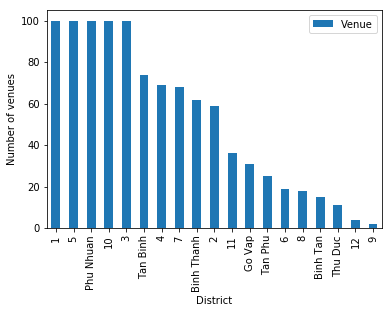

In [29]:
ax = hcm_venues_group.sort_values(by="Venue", ascending=False).plot(x="District", y="Venue", kind="bar")
ax.set_ylabel("Number of venues")

#### No of venues in each category

In [30]:

most_venues = hcm_venues.groupby('Venue Category').count().sort_values(by="Venue", ascending=False)
most_venues.head(15)

,District,District Latitude,District Longitude,Venue,Venue Latitude,Venue Longitude
Venue Category,,,,,,
Vietnamese Restaurant,130,130,130,130,130,130
Café,128,128,128,128,128,128
Coffee Shop,75,75,75,75,75,75
Seafood Restaurant,36,36,36,36,36,36
Hotel,35,35,35,35,35,35
Chinese Restaurant,26,26,26,26,26,26
Vegetarian / Vegan Restaurant,25,25,25,25,25,25
Asian Restaurant,23,23,23,23,23,23
Multiplex,18,18,18,18,18,18


### The number of categories in each district

Text(0, 0.5, 'Number of categories')

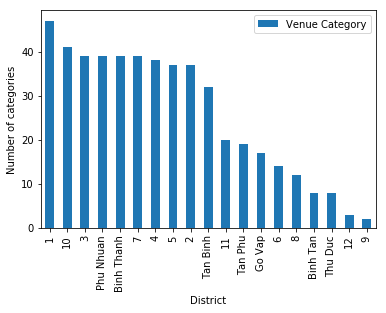

In [31]:
hcm_venues_group_cat = (
    hcm_venues.groupby(['District','Venue Category'])
        .count().reset_index()[['District', 'Venue Category']]
            .groupby('District').count().reset_index()
)
# hcm_venues_group_cat
ax = hcm_venues_group_cat.sort_values(by="Venue Category", ascending=False).plot(x="District", y="Venue Category", kind="bar")
ax.set_ylabel("Number of categories")

### Top 10 venue categories for each district

In [32]:
# one hot encoding
hcm_onehot = pd.get_dummies(hcm_venues[['Venue Category']], prefix="", prefix_sep="")

# add district column back to dataframe
hcm_onehot['District'] = hcm_venues['District'] 

# move district column to the first column
fixed_columns = [hcm_onehot.columns[-1]] + list(hcm_onehot.columns[:-1])
hcm_onehot = hcm_onehot[fixed_columns]

# group the rows by district and by taking the mean of the frequency of occurrence of each category
hcm_grouped = hcm_onehot.groupby('District').mean().reset_index()
hcm_grouped.head()

,District,American Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,BBQ Joint,Bagel Shop,Bakery,...,Thai Restaurant,Theme Park,Travel Agency,Udon Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Warehouse Store,Water Park,Whisky Bar,Yoga Studio
0,1,0.000000,0.0,0.00,0.010000,0.0,0.0,0.010000,0.0,0.000000,...,0.010000,0.000000,0.0,0.000000,0.020000,0.130000,0.0,0.000000,0.01,0.0
1,10,0.000000,0.0,0.01,0.020000,0.0,0.0,0.010000,0.0,0.000000,...,0.010000,0.000000,0.0,0.000000,0.020000,0.200000,0.0,0.000000,0.00,0.0
2,11,0.027778,0.0,0.00,0.027778,0.0,0.0,0.000000,0.0,0.000000,...,0.000000,0.027778,0.0,0.000000,0.027778,0.083333,0.0,0.027778,0.00,0.0
3,12,0.000000,0.0,0.00,0.000000,0.0,0.0,0.000000,0.0,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.250000,0.0,0.000000,0.00,0.0
4,2,0.000000,0.0,0.00,0.016949,0.0,0.0,0.050847,0.0,0.033898,...,0.016949,0.000000,0.0,0.016949,0.000000,0.135593,0.0,0.000000,0.00,0.0


In [48]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['District']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
hcm_10 = pd.DataFrame(columns=columns)
hcm_10['District'] = hcm_grouped['District']

for ind in np.arange(hcm_grouped.shape[0]):
    hcm_10.iloc[ind, 1:] = return_most_common_venues(hcm_grouped.iloc[ind, :], num_top_venues)

hcm_10

,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,1,Hotel,Vietnamese Restaurant,Café,Coffee Shop,Massage Studio,French Restaurant,Pizza Place,Italian Restaurant,Hotel Bar,Hotpot Restaurant
1,10,Vietnamese Restaurant,Café,Coffee Shop,Dessert Shop,Seafood Restaurant,Snack Place,Asian Restaurant,Convenience Store,Market,Gym / Fitness Center
2,11,Café,Chinese Restaurant,Vietnamese Restaurant,Seafood Restaurant,Cantonese Restaurant,American Restaurant,Coffee Shop,Electronics Store,Shopping Mall,Basketball Stadium
3,12,Café,Department Store,Vietnamese Restaurant,Yoga Studio,Food,Flower Shop,Flea Market,Fast Food Restaurant,Electronics Store,Dumpling Restaurant
4,2,Vietnamese Restaurant,Café,Coffee Shop,Restaurant,BBQ Joint,Multiplex,Pizza Place,Burger Joint,Bakery,Bar
5,3,Vietnamese Restaurant,Café,Vegetarian / Vegan Restaurant,Coffee Shop,Hotel,Seafood Restaurant,Breakfast Spot,Asian Restaurant,Noodle House,Spa
6,4,Vietnamese Restaurant,Seafood Restaurant,Coffee Shop,Café,Hotel,Food,Japanese Restaurant,Flea Market,Hostel,Mexican Restaurant
7,5,Chinese Restaurant,Vietnamese Restaurant,Coffee Shop,Dessert Shop,Café,Noodle House,Asian Restaurant,Dim Sum Restaurant,Seafood Restaurant,Vegetarian / Vegan Restaurant
8,6,Asian Restaurant,Supermarket,Café,Flea Market,Fast Food Restaurant,Department Store,Movie Theater,Bookstore,Dessert Shop,Food Court
9,7,Vietnamese Restaurant,Café,Coffee Shop,Seafood Restaurant,Gym / Fitness Center,Flea Market,Sushi Restaurant,Hotel,Soup Place,Spa


# Consider the data relating to category "café" only

In [50]:
hcm_grouped_cafe = hcm_grouped[["District", "Café"]]
hcm_grouped_cafe

,District,Café
0,1,0.070000
1,10,0.170000
2,11,0.250000
3,12,0.500000
4,2,0.067797
5,3,0.130000
6,4,0.043478
7,5,0.060000
8,6,0.105263
9,7,0.073529


We want to cluster districts by the category "Café" only. We will use the K-Means clustering to do this but first we need to determine how many k we need to use. The "elbow" method helps to find a good k.

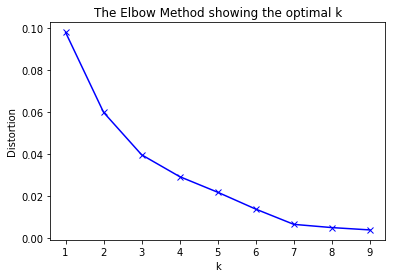

In [51]:
# try with 10 different values of k to find the best one
Ks = 10
distortions = []

hcm_cafe_clustering = hcm_grouped_cafe.drop('District', 1)

for k in range(1, Ks):

    # run k-means clustering
    kmeans = KMeans(n_clusters=k, random_state=0).fit(hcm_cafe_clustering)

    # find the distortion w.r.t each k
    distortions.append(
        sum(np.min(cdist(hcm_cafe_clustering, kmeans.cluster_centers_, 'euclidean'), axis=1))
        / hcm_cafe_clustering.shape[0]
    )

plt.plot(range(1, Ks), distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

We see that, the "elbow" appears at k=3.

In [52]:
nclusters = 3
kmeans = KMeans(n_clusters=nclusters, random_state=0).fit(hcm_cafe_clustering)

In [58]:
df_cafe = hcm_grouped_cafe.copy()
df_cafe["Cluster Labels"] = kmeans.labels_

# add two columns Latitude and Logitude into cafe_merged
df_cafe = df_cafe.join(df.set_index("District"), on="District")

# sort the table by cluster labels
df_cafe.sort_values(["Cluster Labels"], inplace=True)

# Drop some unnecessary columns
df_cafe = df_cafe.drop(["Subdistrict", "Area (km2)"], axis=1)


df_cafe

,District,Café,Cluster Labels,Population 2015,Density (pop/m2),Average Housing Price (1M VND),Latitude,Longitude
1,10,0.170000,0,238558,41705.944,217 /m2,10.773198,106.667833
2,11,0.250000,0,230596,44863.035,167 /m2,10.764208,106.643282
16,Tan Binh,0.189189,0,459029,20510.679,153 /m2,10.797979,106.653805
15,Phu Nhuan,0.190000,0,182477,37392.828,190 /m2,10.800118,106.677042
14,Go Vap,0.258065,0,634146,32124.924,99.4 /m2,10.840150,106.671083
12,Binh Tan,0.266667,0,686474,13229.408,66.6 /m2,10.749809,106.605664
0,1,0.070000,1,193632,25049.418,451 /m2,10.774540,106.699184
13,Binh Thanh,0.129032,1,487985,23506.021,137 /m2,10.804659,106.707848
11,9,0.000000,1,290620,2549.298,48.9 /m2,10.824543,106.818015
10,8,0.000000,1,431969,22521.846,69.4 /m2,10.740400,106.665843


# Visualize the clusters on map

In [59]:
# create map
map_clusters = folium.Map(location=[hcm_lat, hcm_long], zoom_start=11)

# set color scheme for the clusters
x = np.arange(nclusters)
ys = [i+x+(i*x)**2 for i in range(nclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(
        df_cafe['Latitude'], 
        df_cafe['Longitude'], 
        df_cafe['District'], 
        df_cafe['Cluster Labels']
):
    label = folium.Popup(str(poi) + ' - Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

# Examine the range of Average Housing Price (AHP)

Range of AHP
1.Low : $30 &lt; AHP \le 100$.
2.Medium : $100 &lt; AHP \le 200$.
3.High : $200 &lt; AHP \le 300$.
4.Very High : $300 &lt; AHP$.

We can understand the clusters

Cluster 0 : There are not many café shops in these districts.
Cluster 1 : There are a lot of café shops in these districts.
Cluster 2 : The number of café shops in these districts is medium.

# Conclusion
From all above results, we conclude that, the best place for us to set up a new café is in district 4 because there are a lot of people living there (high density), there are not many already-working café (cluster 0) and the average housing price is low.